In [1]:
import numpy as np
import torch as t
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
from ipywidgets import FloatSlider, interact, interact_manual

$$
\newcommand{\bracket}[3]{\left#1 #3 \right#2}
\newcommand{\b}{\bracket{(}{)}}
\newcommand{\Bernoulli}{{\rm Bernoulli}\b}
\newcommand{\x}{\mathbf{x}}
\newcommand{\X}{\mathbf{X}}
\newcommand{\m}{\boldsymbol{\mu}}
\newcommand{\P}{{\rm P}\b}
\newcommand{\dd}[2][]{\frac{\partial #1}{\partial #2}}
\newcommand{\S}{\mathbf{\Sigma}}
\newcommand{\Sh}{\mathbf{\hat{\Sigma}}}
\newcommand{\mh}{\boldsymbol{\hat{\mu}}}
\newcommand{\N}{\mathcal{N}\b}
\newcommand{\det}{\bracket{\lvert}{\rvert}}
\newcommand{\sb}{\bracket{[}{]}}
\newcommand{\E}{\mathbb{E}\sb}
\newcommand{\Var}{{\rm Var}\sb}
\newcommand{\Cov}{{\rm Cov}\sb}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\newcommand{\ph}{\hat{p}}
\newcommand{\at}{\bracket{.}{\rvert}}
\newcommand{\w}{\mathbf{w}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\Wh}{\mathbf{\hat{W}}}
\newcommand{\Y}{\mathbf{Y}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\wh}{\mathbf{\hat{w}}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\0}{\mathbf{0}}
\newcommand{\I}{\mathbf{I}}
$$

<h1> Lecture 1: Supervised learning: classification and regression </h1>

First things first:
<ul>
  <li> I'm experimenting with doing the lectures in Jupyter Notebooks.</li>
  <li> Hopefully, it means we can connect theory and code more closely.</li>
  <li> As much as possible, I'll try to prepare the ground for later deep-leaning and machine learning courses.</li>
  <li> I'm going to use PyTorch, mainly for the distributions library.</li>
  <li> PyTorch's syntax is almost exactly the same as Numpy.</li>
  <li> There may be some repetition from previous lectures, but I'll be doing things much more deeply, with more simulations</li>
</ul>

In supervised learning, we have a bunch of input, $x$, output, $y$, pairs as data.

The great thing about supervised learning is that the inputs and outputs could be almost anything,
```
x :: Image,  y :: Int               # Object recognition
x :: Image,  y :: Matrix{Int}       # Image segmentation
x :: Audio,  y :: Str               # Speech recognition
x :; Str,    y :: Audio             # Text-to-speech
```
The goal is to learn something about the mapping from $x$ to $y$.

One approach is to learn a function that maps from $x$ to a guess about the corresponding $y$.  This guess is called $\hat{y}$,

\begin{align}
  f(x) \rightarrow \hat{y}
\end{align}

To learn $f$, we try to make $y$ from the data as similar as possible to the estimates, $\hat{y}$.

However, to choose this function, we require a measure of "similiarity".  One common example is the squared error,

\begin{align}
  \text{SE} &= \b{y - \hat{y}}^2
\end{align}

However, this approach makes learning difficult for discrete objects, you can't differentiate.

Instead, we usually write a function that takes an $x$ and returns a distribution over $y$,

\begin{align}
  f(x) \rightarrow \P{y| x}
\end{align}

It is easier to fit such a distribution, because we can always maximise the probability of the $y$ that we saw in the data.

Note: classification and regression are special types of supervised learning.  In classification, the output is, a class-label,
```
Y = Int     #classification
```
in regression, the output is one (or many) real values,
```
Y = Float   #regression
```
If the output is more complicated (e.g. a string, image or audio), then its neither regression or classification, its just supervised learning.

<h2> Multivariate linear regression </h2>

The most useful and instructive supervised learning method is multivariate linear regression.

The input for the $\lambda$th data point is, $\x$, is a vector and we consider the multi-output case, where the corresponding output, $\y_\lambda$ is also a vector.
We assume that $\y_\lambda$ is Gaussian, conditioned on $\x$,

\begin{align}
  \P{y_\lambda| \x_\lambda, \w} &= \N{y_\lambda; \x_\lambda \cdot \w, \sigma^2}.
\end{align}

It turns out to be easier to write this as a multivariate Gaussian over all outputs, $\y$, jointly,

\begin{align}
  \P{\y| \X, \w} &= \N{\y; \X \w, \sigma^2 \I}
\end{align}

Writing the log-probability out in full,

\begin{align}
  \L\b{\w} &= \log \P{\y| \X, \w} = \sum_{\lambda} \sb{ -\tfrac{1}{2} \log 2 \pi \sigma^2 - \tfrac{1}{2 \sigma^2} \b{Y_{\lambda} - \sum_i X_{\lambda i} w_i}^2}.
\end{align}

The maximum likelihood estimate, $\wh$, is the maximum of the log-likelihood,

\begin{align}
  \wh &= \argmax_\w \L\b{\w}
\end{align}

To compute the maximum, we take the gradient,

\begin{align}
  \dd[\L\b{\w}]{w_\alpha} &= - \frac{1}{2 \sigma^2} \dd{w_\alpha} \sum_\lambda \b{y_\lambda - \sum_i X_{\lambda i} w_i}^2.
\end{align}

This looks hard.  But because we've written it in index notation, we can do everything in terms of standard calculus.  We start by applying the chain rule,

\begin{align}
  \dd[\L\b{\w}]{w_\alpha} &= - \frac{1}{\sigma^2} \sum_{\lambda} \b{y_\lambda - \sum_i X_{\lambda i} w_i} \dd{w_\alpha} \b{y_\lambda - \sum_i X_{\lambda i} w_i}.
\end{align}

interlude: the Kronecker delta (which looks alot like an identity matrix),

\begin{align}
  \dd[w_i]{w_\alpha} = \delta_{i \alpha}\\
  \delta_{i\alpha} = \begin{cases}
    1 & \text{ if } i = \alpha\\
    0 & \text{ if } i \neq \alpha
  \end{cases}
\end{align}

thus,

\begin{align}
  \dd[\L\b{\w}]{w_\alpha} &= \frac{1}{\sigma^2} \sum_{\lambda} \b{y_\lambda - \sum_i X_{\lambda i} w_i} \sum_i \delta_{i \alpha} X_{\lambda i} .
\end{align}

the $\delta_{i \alpha}$ picks out the $i=\alpha$ term in the sum,

\begin{align}
  \dd[\L\b{\w}]{w_\alpha} &= \frac{1}{\sigma^2} \sum_{\lambda} \b{y_\lambda - \sum_i X_{\lambda i} w_i} X_{\lambda \alpha} .
\end{align}

Finally, put everything back in vector/matrix notation,

\begin{align}
  \dd[\L\b{\w}]{\w} &= \tfrac{1}{\sigma^2} \X^T \b{\y - \X \w}
\end{align}

We could just follow the gradient uphill (and that's what we do in deep learning), but this is super-slow.  Instead, there's an answer that is much faster to compute: at the top of the hill, the gradient is zero,

\begin{align}
  \0 &= \at{\dd[\L\b{\w}]{\w}}_{\w=\wh}\\ 
  \0 &= \tfrac{1}{\sigma^2} \X^T \b{\y - \X \wh} \\
  \0 &= \X^T \y - \X^T \X \wh \\
  \X^T \X \wh &= \X^T \y
\end{align}

Note that we can't just solve for $\wh$ using the inverse of $\X^T$ because it is almost never square, so the inverse does not exist!  As, $\X^T \X$ is square, we can take its inverse (note that $\X^T$ isn't square, so we can't take its inverse,)

\begin{align}
  \wh  &= \b{\X^T \X}^{-1} \X^T \y 
\end{align}


I've done it this way, because the translation into Numpy/PyTorch is most direct, but if you look things up, you will often find the transposes in different places.

Lets write some code!  First, we can directly translate the above expression to give a method for fitting $\Wh$,

In [2]:
def fit_Wh(X, Y):
    return t.inverse(X.T @ X) @ X.T @ Y

Now we generate some 1D "fake data"

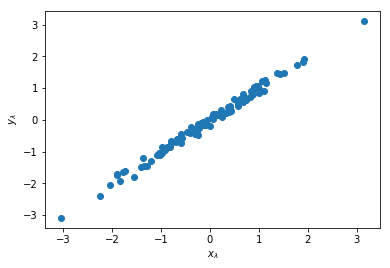

In [3]:
N     = 100 # number of datapoints
D     = 1   # dimension of datapoints
sigma = 0.1 # output noise
X     = t.randn(N, D)
Wtrue = t.ones(D, 1)
Y     = X @ Wtrue + sigma*t.randn(N, 1)

fig, ax = plt.subplots()
ax.set_xlabel("$x_\lambda$")
ax.set_ylabel("$y_\lambda$")
ax.scatter(X, Y);

In [4]:
Wh = fit_Wh(X, Y)
print(f"Wtrue = {Wtrue.T}")
print(f"Wh    = {Wh.T}")

Wtrue = tensor([[1.]])
Wh    = tensor([[0.9971]])


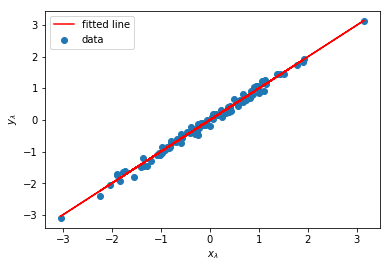

In [5]:
fig, ax = plt.subplots()
ax.set_xlabel("$x_\lambda$")
ax.set_ylabel("$y_\lambda$")
ax.scatter(X, Y, label="data")
ax.plot(X, X@Wh, 'r', label="fitted line")
ax.legend();

Now we can also generate some 2D "fake data",

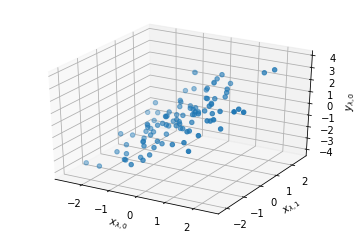

In [7]:
N     = 100 # number of datapoints
D     = 2   # dimension of datapoints
sigma = 0.3 # output noise
X     = t.randn(N, D)
Wtrue = t.ones(D, 1)
Y     = X @ Wtrue + sigma*t.randn(N, 1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("$x_{\lambda, 0}$")
ax.set_ylabel("$x_{\lambda, 1}$")
ax.set_zlabel("$y_{\lambda, 0}$")
ax.scatter(xs=X[:, 0], ys=X[:, 1], zs=Y[:, 0]);

In [8]:
Wh = fit_Wh(X, Y)
print(f"Wtrue = {Wtrue.T}")
print(f"Wh    = {Wh.T}")

Wtrue = tensor([[1., 1.]])
Wh    = tensor([[1.0055, 1.0081]])


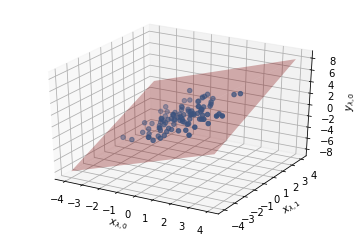

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("$x_{\lambda, 0}$")
ax.set_ylabel("$x_{\lambda, 1}$")
ax.set_zlabel("$y_{\lambda, 0}$")
ax.scatter(X[:, 0], X[:, 1], Y[:, 0])

Xp = t.tensor([
    [-4., -4.],
    [-4.,  4.],
    [ 4., -4.],
    [ 4.,  4.]
])

ax.plot_trisurf(
    np.array(Xp[:, 0]), 
    np.array(Xp[:, 1]), 
    np.array((Xp @ Wh)[:, 0]), 
    color='r', 
    alpha=0.3
);

But there are issues with linear regression, as formulated thus far.

In particular, consider 1D data, generated with a bias,

\begin{align}
  \P{y_\lambda| \x_\lambda, w, b} &= \N{\y_\lambda; x_\lambda w + b, \sigma^2}
\end{align}

If we fit our old model, without a bias, it doesn't work,

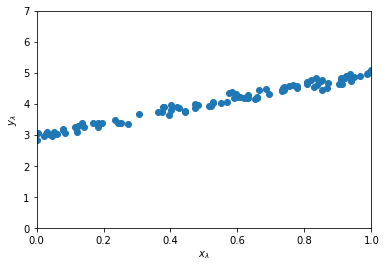

In [10]:
N     = 100 # number of datapoints
D     = 1   # dimension of datapoints
sigma = 0.1 # output noise
X     = t.rand(N, D)
Wtrue = 2*t.ones(D, 1)
btrue = 3
Y     = X @ Wtrue + btrue + sigma*t.randn(N, 1)

fig, ax = plt.subplots()
ax.set_xlabel("$x_\lambda$")
ax.set_ylabel("$y_\lambda$")
ax.set_xlim(0, 1)
ax.set_ylim(0, 7)
ax.scatter(X, Y);

In [11]:
Wh = fit_Wh(X, Y)
print(f"Wtrue = {Wtrue.T}")
print(f"Wh    = {Wh.T}")

Wtrue = tensor([[2.]])
Wh    = tensor([[6.2366]])


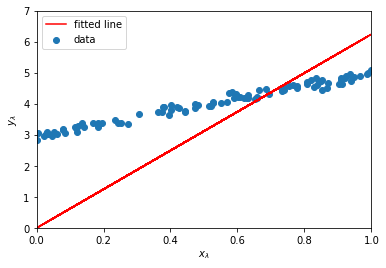

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel("$x_\lambda$")
ax.set_ylabel("$y_\lambda$")
ax.set_xlim(0, 1)
ax.set_ylim(0, 7)
ax.scatter(X, Y, label="data")
ax.plot(X, X@Wh, 'r', label="fitted line")
ax.legend();

What can we do?  Well, we could go through the big derivation above again, incorporating the bias.

But this is super-tedious.

Instead, note that if we expand the 1D feature vector into a 2D feature vector, with the second feature being just biases,

\begin{align}
  \P{y_\lambda| \x_\lambda, w, b} &= \N{\y_\lambda; \underbrace{\begin{pmatrix} x_\lambda & 1 \end{pmatrix}}_\text{expanded feature vector} \overbrace{\begin{pmatrix} w \\ b \end{pmatrix}}^\text{expanded weight vector}, \sigma^2}.
\end{align}

Now, we can just use our original derivation, and implementation!

In [13]:
def add_bias(X):
    return t.cat([X, t.ones(X.shape[0], 1)], 1)

Xe = add_bias(X)
Xe[:10, :]

tensor([[8.4282e-01, 1.0000e+00],
        [7.3414e-01, 1.0000e+00],
        [2.8753e-02, 1.0000e+00],
        [1.8394e-01, 1.0000e+00],
        [2.2328e-04, 1.0000e+00],
        [6.5846e-01, 1.0000e+00],
        [6.9464e-01, 1.0000e+00],
        [1.1606e-01, 1.0000e+00],
        [1.8210e-01, 1.0000e+00],
        [7.7717e-01, 1.0000e+00]])

In [14]:
Wh = fit_Wh(Xe, Y)
print(f"Wh    = {Wh.T}")
print(f"Wtrue = {Wtrue}")
print(f"btrue = {btrue}")

Wh    = tensor([[2.0150, 2.9741]])
Wtrue = tensor([[2.]])
btrue = 3


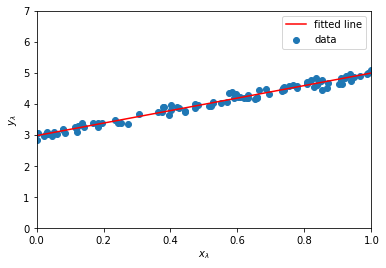

In [15]:
fig, ax = plt.subplots()
ax.set_xlabel("$x_\lambda$")
ax.set_ylabel("$y_\lambda$")
ax.set_xlim(0, 1)
ax.set_ylim(0, 7)
ax.scatter(X, Y, label="data")

xs = t.tensor([[0.], [1.]])
ax.plot(xs, add_bias(xs)@Wh, 'r', label="fitted line")
ax.legend();

It turns out that this idea can be taken *much* further.

In particular, instead of just incorporating a constant feature, we can incorporate arbitrary, nonlinear *functions* of the original input data.

For instance,

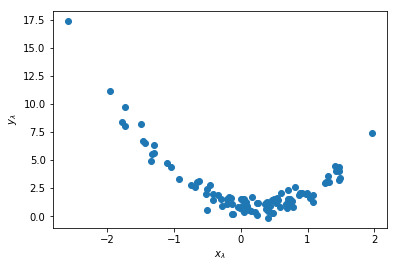

In [16]:
N     = 100 # number of datapoints
D     = 1   # dimension of datapoints
sigma = 0.5 # output noise
X     = t.randn(N, D)
qtrue = 2  # quadratic term
ltrue = -1 # linear term
btrue = 1  # bias
Y     = qtrue*X**2 + ltrue*X + btrue + sigma*t.randn(N, 1)

fig, ax = plt.subplots()
ax.set_xlabel("$x_\lambda$")
ax.set_ylabel("$y_\lambda$")
ax.scatter(X, Y);

In [17]:
def quad(X):
    return t.cat([X**2, X, t.ones(X.shape[0], 1)], 1)

Xe = quad(X)
Xe[:10, :]

tensor([[ 0.1724,  0.4153,  1.0000],
        [ 0.0854, -0.2922,  1.0000],
        [ 0.6592,  0.8119,  1.0000],
        [ 0.1325,  0.3641,  1.0000],
        [ 0.0193, -0.1388,  1.0000],
        [ 0.1433,  0.3785,  1.0000],
        [ 0.0441,  0.2101,  1.0000],
        [ 0.0155, -0.1245,  1.0000],
        [ 0.1719, -0.4147,  1.0000],
        [ 0.8437,  0.9186,  1.0000]])

In [18]:
Wh = fit_Wh(Xe, Y)
print(f"Wh    = {Wh.T}")
print(f"qtrue = {qtrue}")
print(f"ltrue = {ltrue}")
print(f"btrue = {btrue}")

Wh    = tensor([[ 2.0745, -0.9758,  0.9910]])
qtrue = 2
ltrue = -1
btrue = 1


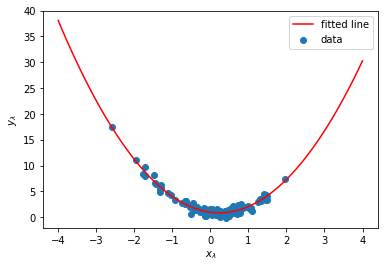

In [19]:
fig, ax = plt.subplots()
ax.set_xlabel("$x_\lambda$")
ax.set_ylabel("$y_\lambda$")

ax.scatter(X, Y, label="data")

xs = t.linspace(-4, 4, 100)[:, None]
ax.plot(xs, quad(xs)@Wh, 'r', label="fitted line")
ax.legend();